In [7]:
from ds_class import Dstar
import numpy as np
import os
import gym
from Enviroment import Enviroment
from gym import spaces
import cv2
import matplotlib.pyplot as plt


In [37]:
class CustomEnv(gym.Env):
    '''
    Оборочивание класса среды в среду gym
    '''
    metadata = {'render.modes': ['human']}

    def __init__(self, obstacle_turn: bool, Total_war: bool, num_obs, num_enemy: int, inp_dim: int,
                 size_obs, steps_limit, vizualaze = False, head_velocity = 0.01, rew_col = -70,
                 rew_win = 100, rew_defeat = -100 , EnemyLidSet = [120, 120] , AllyLidSet = [50, 90]):
        '''
        Инициализация класса среды
        :param obstacle_turn: (bool) Флаг генерации препятствий
        :param vizualaze: (bool) Флаг генерации препятствий
        :param Total_war: (bool) Флаг режима игры (с противником или без)
        :param steps_limit: (int) Максимальное количество действий в среде за одну игру
        '''
        self.log_koef = 50
        self.ang_Norm_coef = np.pi
        self.coords_Norm_coef = 500
        self.inp_dim = inp_dim
        
        # optionEnemy = [120, 120]     # настройки противника [0] - дальность СТЗ; [1] - угол СТЗ (градусы)
        # optionAlie = [50, 90]        # настройки союзника [0] - дальность СТЗ; [1] - угол СТЗ (градусы)
        
        self.obstacle_turn = obstacle_turn
        self.Total_war = Total_war
        self.num_obs = num_obs
        self.num_enemy = num_enemy
        self.size_obs = size_obs
        self.steps_limit = steps_limit
        self.vizualaze = vizualaze
        self.head_velocity = head_velocity
        self.rew_col = rew_col
        self.rew_win = rew_win
        self.rew_defeat = rew_defeat
        self.EnemyLidSet = EnemyLidSet
        self.AllyLidSet = AllyLidSet
        
        self.enviroment = Enviroment(self.obstacle_turn, self.vizualaze, self.Total_war,
                                     self.head_velocity, self.num_obs, self.num_enemy, 
                                     self.size_obs, self.steps_limit, self.rew_col, 
                                     self.rew_win, self.rew_defeat, epsilon = 100,
                                     sigma = 30, optionEnemy = self.EnemyLidSet, optionAlie = self.AllyLidSet)

        self.action_space = spaces.Discrete(8)
        self.observation_space = gym.spaces.Dict({
                    'img': spaces.Box(low=0, high=255, shape=(self.inp_dim, self.inp_dim, 3), dtype=np.uint8),
                    'posRobot': spaces.Box(low=np.array([0, 0,-3.14]), high=np.array([500, 500, 3.14])),
                    'target':   spaces.Box(low=np.array([0, 0,-3.14]), high = np.array([500, 500, 3.14]))
                                                })

        state = self.enviroment.reset()
    
    def step(self, action):
        """
        Метод осуществления шага в среде
        :param action: (int) направление движения в среде
        :return: dict_state, reward, not done, {}: состояние, реворд, флаг терминального состояния, информация о среде
        """
        
        state, reward, done, numstep = self.enviroment.step(action)
        # state.img = cv2.resize(state.img, (self.inp_dim,self.inp_dim))
            
        x2 = state.posRobot[0]
        y2 = state.posRobot[1]
    
        x4 = state.target[0,0]
        y4 = state.target[0,1]
        
        
        f2 =  state.target[0,2]
        f2 = np.deg2rad(f2)
        
        Ax4, Ay4 = -np.cos(f2), np.sin(f2)
        Bx24, By24 = x2 - x4, y2 - y4

        dist = - np.sqrt(np.abs((x2-x4)**2 + (y2-y4)**2))
        phy = (Ax4*Bx24 + Ay4*By24)/(np.sqrt(Ax4**2 + Ay4**2) * np.sqrt(Bx24**2 + By24**2))
        reward_l = phy*(dist+500) * 0.01 * (not done) + np.round(reward, 2).sum()

        return state, reward_l, done, {}

    def reset(self):
        '''
        Метод обновления игры
        :return: dict_state: состояние
        '''
                
        state = self.enviroment.reset()
        return state

    def render(self, model, num_gifs=1):
        '''
        Метод вывода информации об игре
        :param mode:
        :return:
        '''
        for i in range(num_gifs):
            
            images = []
            obs = self.reset()
            img = obs['img']# env.render(mode='rgb_array')
            done = False
                
            height, width, layers = img.shape
            size = (width,height)
            out = cv2.VideoWriter(f"video{i}.avi",cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            out.write(img)
            while not done:

                action, _ = model.predict(obs)
                obs, _, done ,_ = self.step(action)
                img = obs['img']
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                out.write(img)
            out.release()
    
    def get_statistic(self, model, num_games):
        collision = 0
        win = 0
        destroyed = 0
        loss = 0
        
        pbar = tqdm(range(num_games))
        for i in pbar:
            obs = self.reset()
            done = False
            while not done:
                action, _ = model.predict(obs)
                obs, reward, done ,_ = self.step(action)
                
            if reward == self.rew_col:#win
                collision+=1
            elif reward == self.rew_win:# loss
                win +=1
            elif reward == self.rew_defeat:# loss
                destroyed +=1
            else:    #not_achieved
                loss+=1
        
        print("Win: ",win/num_games)
        print("destroyed: ", destroyed/num_games)
        print("loss: ",loss/num_games)
        print("collision: ",collision/num_games)

In [44]:
env = CustomEnv(obstacle_turn = True,
                vizualaze     = True, 
                Total_war     = True,
                inp_dim       = 500,
                head_velocity = 0.0,#0.005
                num_obs       = 5, 
                num_enemy     = 1, 
                size_obs      = [50, 60],
                rew_col       = -70,
                rew_win       = 100,
                rew_defeat    = -100,
                steps_limit   = 2000,
                EnemyLidSet   = [45,90],
                AllyLidSet    = [40, 90])

In [39]:
# state = env.reset()

In [50]:
direct_dict = {
                (0, 1): 6,
                (-1, 1): 5,
                (-1, 0): 4,
                (-1, -1): 3,
                (0, -1): 2,
                (1, -1): 1,
                (1, 0): 0,
                (1, 1): 7,
            }

In [51]:
def get_height_map(map):
    kernel = np.array([[1, 4, 6, 4, 1],
                       [4, 16, 24, 16, 4],
                       [6, 24, 36, 24, 6],
                       [4, 16, 24, 16, 4],
                       [1, 4, 6, 4, 1]])
    
    new_map = cv2.filter2D(map, -1, kernel)
    
    for i in range(7):
        new_map = cv2.filter2D(new_map, -1, kernel)/100
        new_map = np.clip(new_map, 0, 65000)
    
    return new_map

In [52]:
done = False
state = env.reset()

while not done:
    heigh_map = get_height_map(state.img_D_star)
    d_goal = [int(state.target[0,0]),int(state.target[0,1])]
    d_start = [state.posRobot[0],state.posRobot[1]]
    
    d_star = Dstar(heigh_map, d_goal, d_start, heigh_map)
    d_star.Move_plan()
    d_star_path = d_star.query(d_start)
    
    act = direct_dict[tuple(d_star_path[1] - d_star_path[0])]
    print(act)
    state, rew, done, info = env.step(act)
        

5
5
5
5
5
5
5
5
5
5
5
5
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
4
4
4
4
4
4


In [29]:
d_star_path[1] - d_star_path[0]

array([-1, -1])

In [35]:
act = direct_dict[tuple(d_star_path[1] - d_star_path[0])]

3

In [8]:
d_goal = [int(state.target[0,0]),int(state.target[0,1])]
d_start = [state.posRobot[0],state.posRobot[1]]

dworld = new_map

In [9]:
d_star = Dstar(dworld, d_goal, d_start, dworld)
d_star.Move_plan()
d_star_path = d_star.query(d_start)
# print(d_star_path)


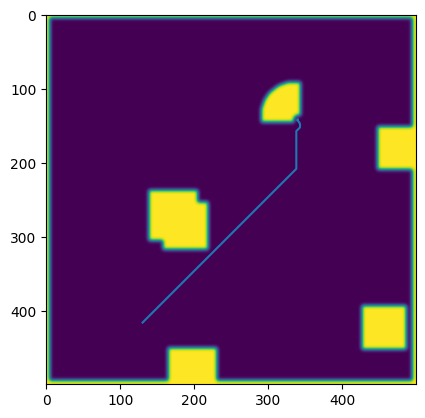

In [12]:
# plt.imshow(dworld)
# plt.plot(x, y)